In [1]:
import tweepy
from tweepy import OAuthHandler
from tweepy import Cursor
from unidecode import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from sklearn import mixture as mix

def read_key(path):
    with open(path, 'r') as f:
        api_key = f.read().replace('\n','')
    return api_key
def get_api():
    consumer_key = read_key("consumer_key.txt")
    consumer_secret = read_key("consumer_secret.txt")
    access_token = read_key("access_token.txt")
    access_secret = read_key("access_token_secret.txt")

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
 
    return tweepy.API(auth, wait_on_rate_limit = True)

def read_words(path):
    words = {}
    with open(path, 'r') as f:
        for i in f.read().split("\n"):
            words[i] = 1
    return words

In [2]:
#source: https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt
happy_words = read_words("positive-words.txt")
sad_words = read_words("negative-words.txt")

def count_words(lst, words):
    count = 0
    for i in lst:
        if i in words:
            count += 1
    return count

def get_tweet_info(api, users, num_items):
    #source: https://gist.github.com/nicolewhite/167828e51d8f2b6fad75
    #might need to normalize all of these
    #lat, long, box_A, box_B, box_C, box_D, place_type(one hot), direct_reply(1 or 0), retweet_or_not(1 or 0),
    #quote or not(1 or 0), created at year, month(sine and cosine transform), number of hashtags, number of user mentions,
    #number of media elements, possibly sensitive or not(1 or 0), english or not(1 or 0), reply_count, quote_count
    #and some tweet word features, favourite count, "urls"
    #retweet_count is the label
    cols = ["direct_reply", "year", "month_sin",
                                      "month_cos", "time_since_posted", "is_quote", "hashtags", 
                                       "user_mentions", "medias", "urls",
                                      "english", "favourites", "happy_words", "sad_words", "retweets"]
    counter = 0
    features = pd.DataFrame(columns = cols)
    #print(features)
    #add the one hot ones and tweet word ones later
    users = Cursor(api.list_members, owner_screen_name = "richarda", slug = "top-50-us-politics").items()
    #print(len(users))
    for user in users:
        print(counter)
        #print(type(user))
        #print(user)
        #user_obj = api.get_user(user)
        
        tweet_count = 0
        for tweet in Cursor(api.user_timeline, screen_name = user.screen_name).items(num_items):
            # Latitude and longitude stored as array of floats within a dictionary.
            '''lat = tweet.coordinates['coordinates'][1]
            long = tweet.coordinates['coordinates'][0]
            box_A = tweet.place['coordinates'][0]
            box_B = tweet.place['coordinates'][1]
            box_C = tweet.place['coordinates'][2]
            box_D = tweet.place['coordinates'][3]'''
            direct_reply = 1 if tweet.in_reply_to_screen_name is not None else 0
            year = tweet.created_at.year
            month_sin = np.sin(2 * np.pi * tweet.created_at.month / 12)
            month_cos = np.cos(2 * np.pi * tweet.created_at.month / 12)
            time_since_posted = (datetime.datetime.now() - tweet.created_at + datetime.timedelta(hours = 4)).total_seconds()
            is_quote = 1 if tweet.is_quote_status else 0
            hashtags = len(tweet.entities.get('hashtags', None))
            med = tweet.entities.get('media', None)
            if med == None:
                medias = 0
            else:
                medias = len(med)
            us = tweet.entities.get('user_mentions', None)
            if us == None:
                user_mentions = 0
            else:
                user_mentions = len(us)
            ur = tweet.entities.get('urls', None)
            if ur == None:
                urls = 0
            else:
                urls = len(ur)
            english = 1 if tweet.lang == "en" else 0
            favourites = tweet.favorite_count
            retweets = tweet.retweet_count
            tweet_words = tweet.text.split()
            features.loc[counter] = [direct_reply,
                           year, month_sin, month_cos, time_since_posted, is_quote, hashtags,
                            user_mentions, medias, urls, english, favourites, count_words(tweet_words, happy_words),
                            count_words(tweet_words, sad_words), retweets]
            counter += 1
    '''places = features["place_type"].unique()
    for place in places:
        features[place] = features["place_type"].map(lambda x: 1 if x == place else 0)
    return features.drop("place_type", 1)'''
    '''min_year = min(features["year"])
    year_range = max(features["year"]) - min_year
    features["year"] = features["year"].map(lambda x: (x - min_year) / year_range)
    
    min_fav = min(features["favourites"])
    fav_range = max(features["favourites"]) - min_fav
    features["favourites"] = features["favourites"].map(lambda x: (x - min_fav) / fav_range)
    
    min_retweet = min(features["retweets"])
    retweet_range = max(features["retweets"]) - min_retweet
    features["retweets"] = features["retweets"].map(lambda x: (x - min_retweet) / retweet_range)
    
    min_happy = min(features["happy_words"])
    happy_range = max(features["happy_words"]) - min_happy
    features["happy_words"] = features["happy_words"].map(lambda x: (x - min_happy) / happy_range)
    
    min_sad = min(features["sad_words"])
    sad_range = max(features["sad_words"]) - min_sad
    features["sad_words"] = features["sad_words"].map(lambda x: (x - min_sad) / sad_range)'''
    
    
    return features
    
            

In [22]:
users = ["top-50-us-politics"]

api = get_api()
df = get_tweet_info(api, users, 60)

0
60
120
180
240
300
313
373
433
493
553
613
673
733
793
853
913
973
1033
1093
1153
1213
1273
1333
1393
1453
1513
1573
1633
1693
1753
1813
1873
1933
1993
2053
2113
2173
2233
2293
2353
2413
2473
2533
2593
2653
2713
2773
2833
2893
2953
3013
3073
3133
3193
3253
3313
3373
3433
3493
3553
3613
3673
3733
3793
3853
3913
3973
4033
4093
4153
4213
4273
4333
4393
4453
4513
4573
4633
4693
4753
4813
4813
4873
4933
4993
5053
5113
5173
5233
5293
5353
5413
5473
5533
5593
5653
5713
5773
5833
5893
5953
6013
6073
6133
6193
6253
6313
6373
6433
6493
6553
6613
6673
6733
6793
6853
6913
6973
7033
7093
7153
7213
7273
7333
7393
7453
7513
7573
7633
7693
7753
7813
7873
7933
7993
8053
8113
8173
8233
8293
8353
8413
8473
8533
8593
8653
8713
8773
8833
8893
8953
9013
9073
9133
9193
9253
9313
9373
9433
9493
9553
9613
9673
9733
9793
9853
9913
9973
10033
10093
10153
10213
10273
10333
10393


In [43]:
print(df.head())

   direct_reply    year  month_sin  month_cos  time_since_posted  is_quote  \
0           0.0  2018.0   0.866025       -0.5         322.958494       0.0   
1           0.0  2018.0   0.866025       -0.5       10595.961961       1.0   
2           0.0  2018.0   0.866025       -0.5       10808.963941       1.0   
3           0.0  2018.0   0.866025       -0.5       11435.966046       0.0   
4           0.0  2018.0   0.866025       -0.5       42523.967877       0.0   

   hashtags  user_mentions  medias  urls  english  favourites  happy_words  \
0       0.0            3.0     0.0   0.0      1.0         0.0          1.0   
1       0.0            0.0     0.0   1.0      1.0      1489.0          1.0   
2       0.0            1.0     0.0   0.0      1.0         0.0          0.0   
3       2.0            2.0     0.0   0.0      1.0         0.0          0.0   
4       0.0            4.0     0.0   0.0      1.0         0.0          1.0   

   sad_words  retweets  
0        0.0       6.0  
1        0.0

In [23]:
df.to_csv("politicians_tweet_data2.csv")

In [14]:
print(df.columns)

Index(['direct_reply', 'year', 'month_sin', 'month_cos', 'is_quote',
       'hashtags', 'user_mentions', 'medias', 'urls', 'english', 'favourites',
       'happy_words', 'sad_words', 'retweets'],
      dtype='object')


In [3]:
df = pd.read_csv("politicians_tweet_data.csv", index_col = 0)

In [3]:
df2 = pd.read_csv("politicians_tweet_data2.csv", index_col = 0)

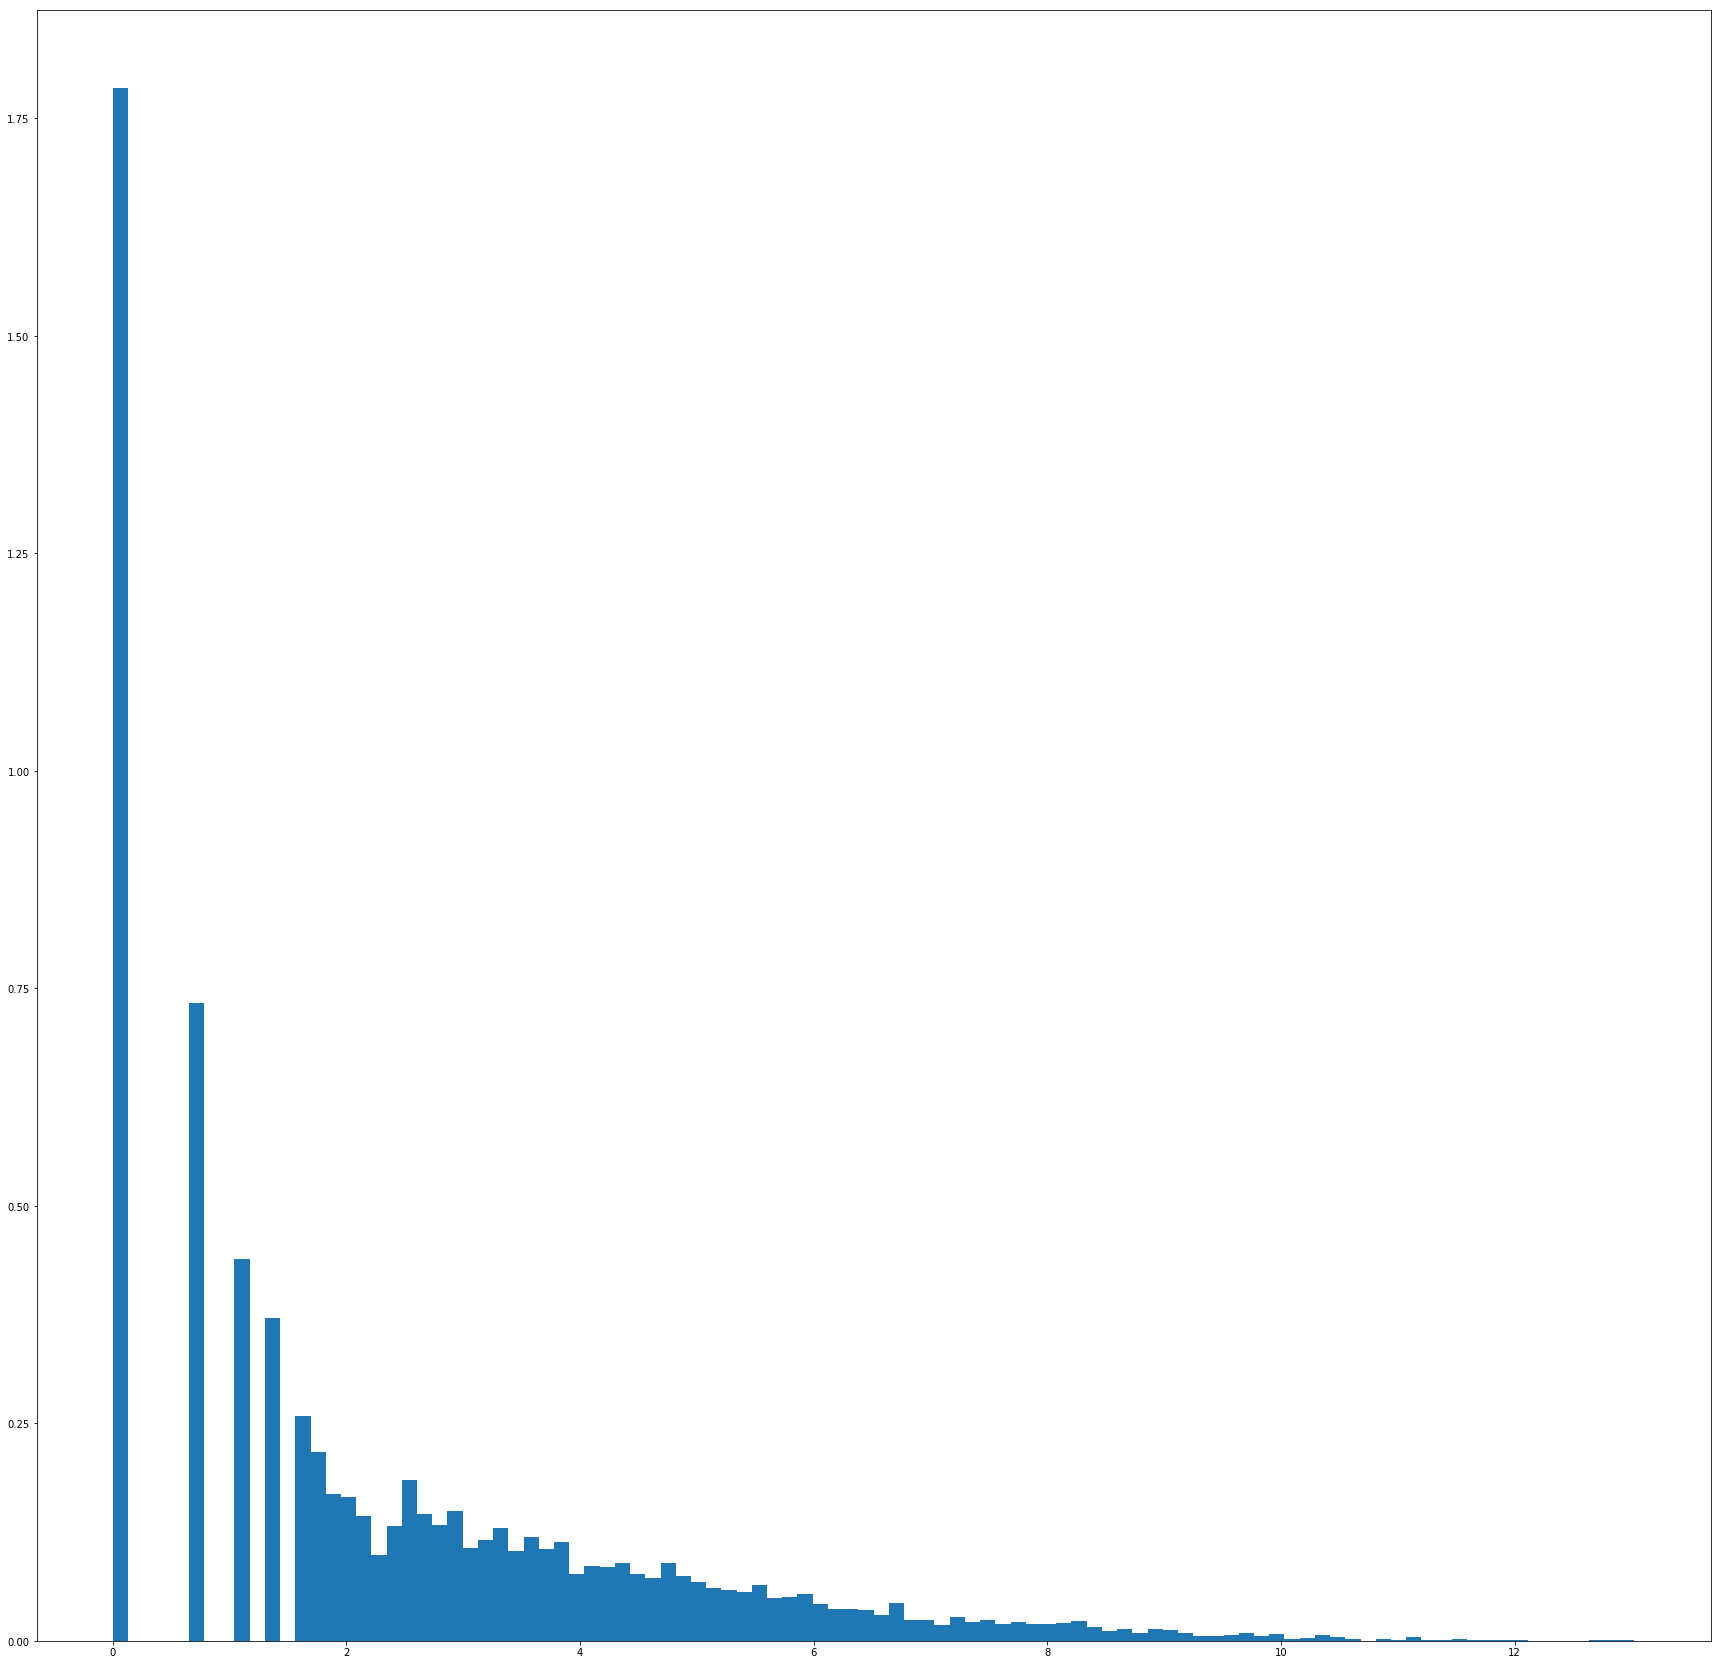

In [4]:
matplotlib.rcParams["figure.figsize"] = [30, 30]
log_retweets = np.log(df["retweets"] + 1)
#min_tweet = min(log_retweets)
#max_tweet = max(log_retweets)
#tweet_range = max_tweet - min_tweet
#plt.hist((log_retweets - min_tweet) / tweet_range, bins = 100)
plt.hist(log_retweets, bins = 100, density = True)
plt.show()

In [8]:
log_retweets = np.log(df["retweets"] + 1)
log_retweets2 = log_retweets[log_retweets != 0]

In [9]:
min_log = min(log_retweets2)
max_log = max(log_retweets2)
log_retweets2 = (log_retweets2 - min_log) * 5 / (max_log - min_log)

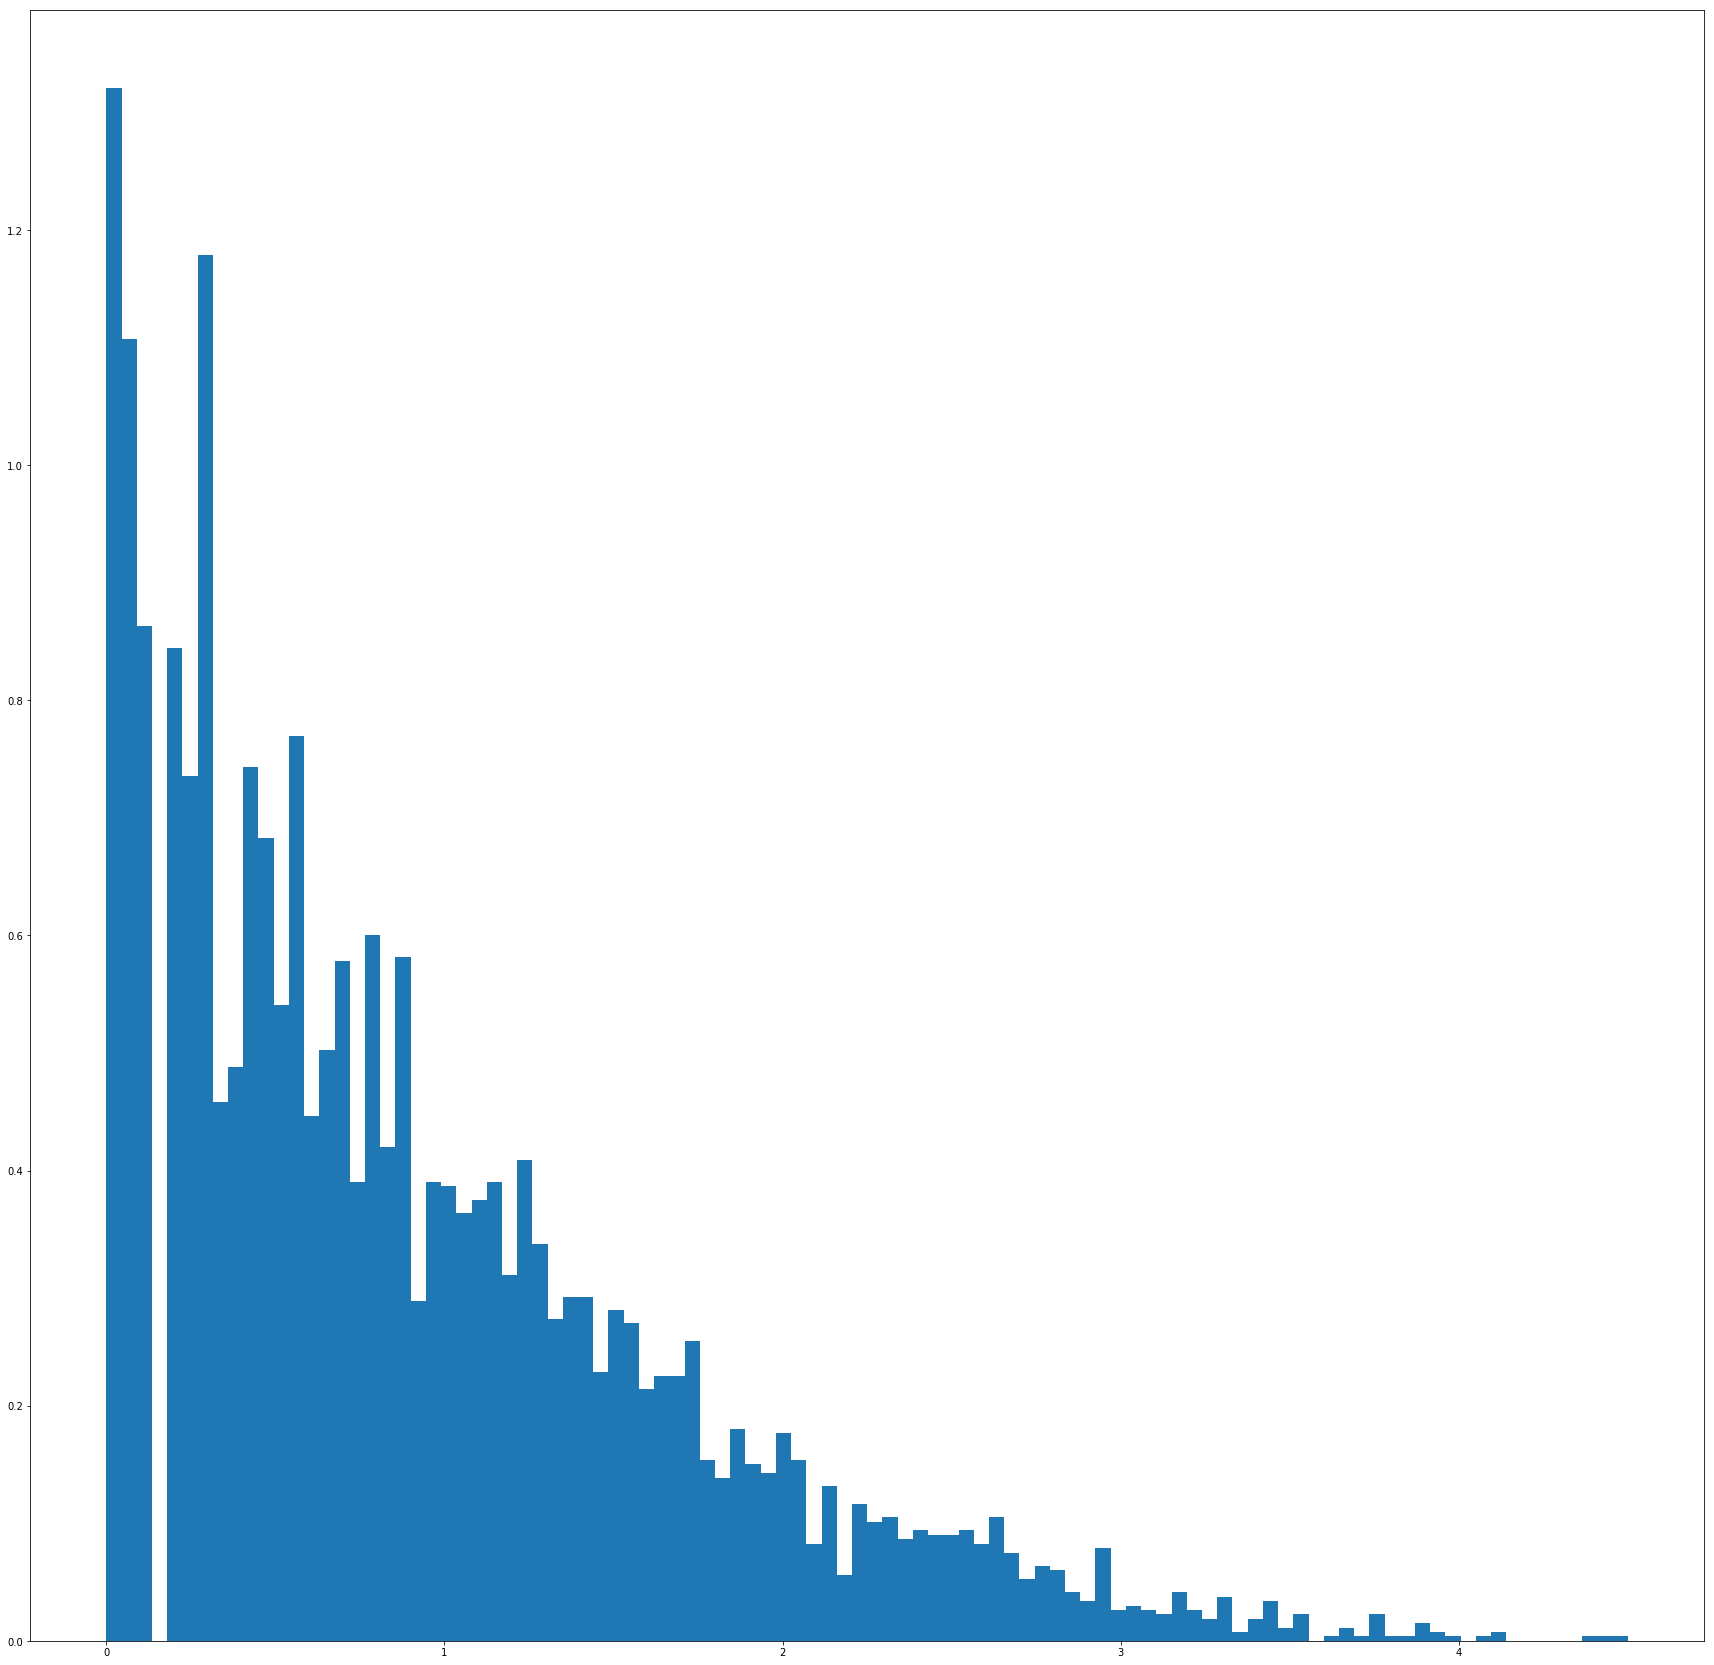

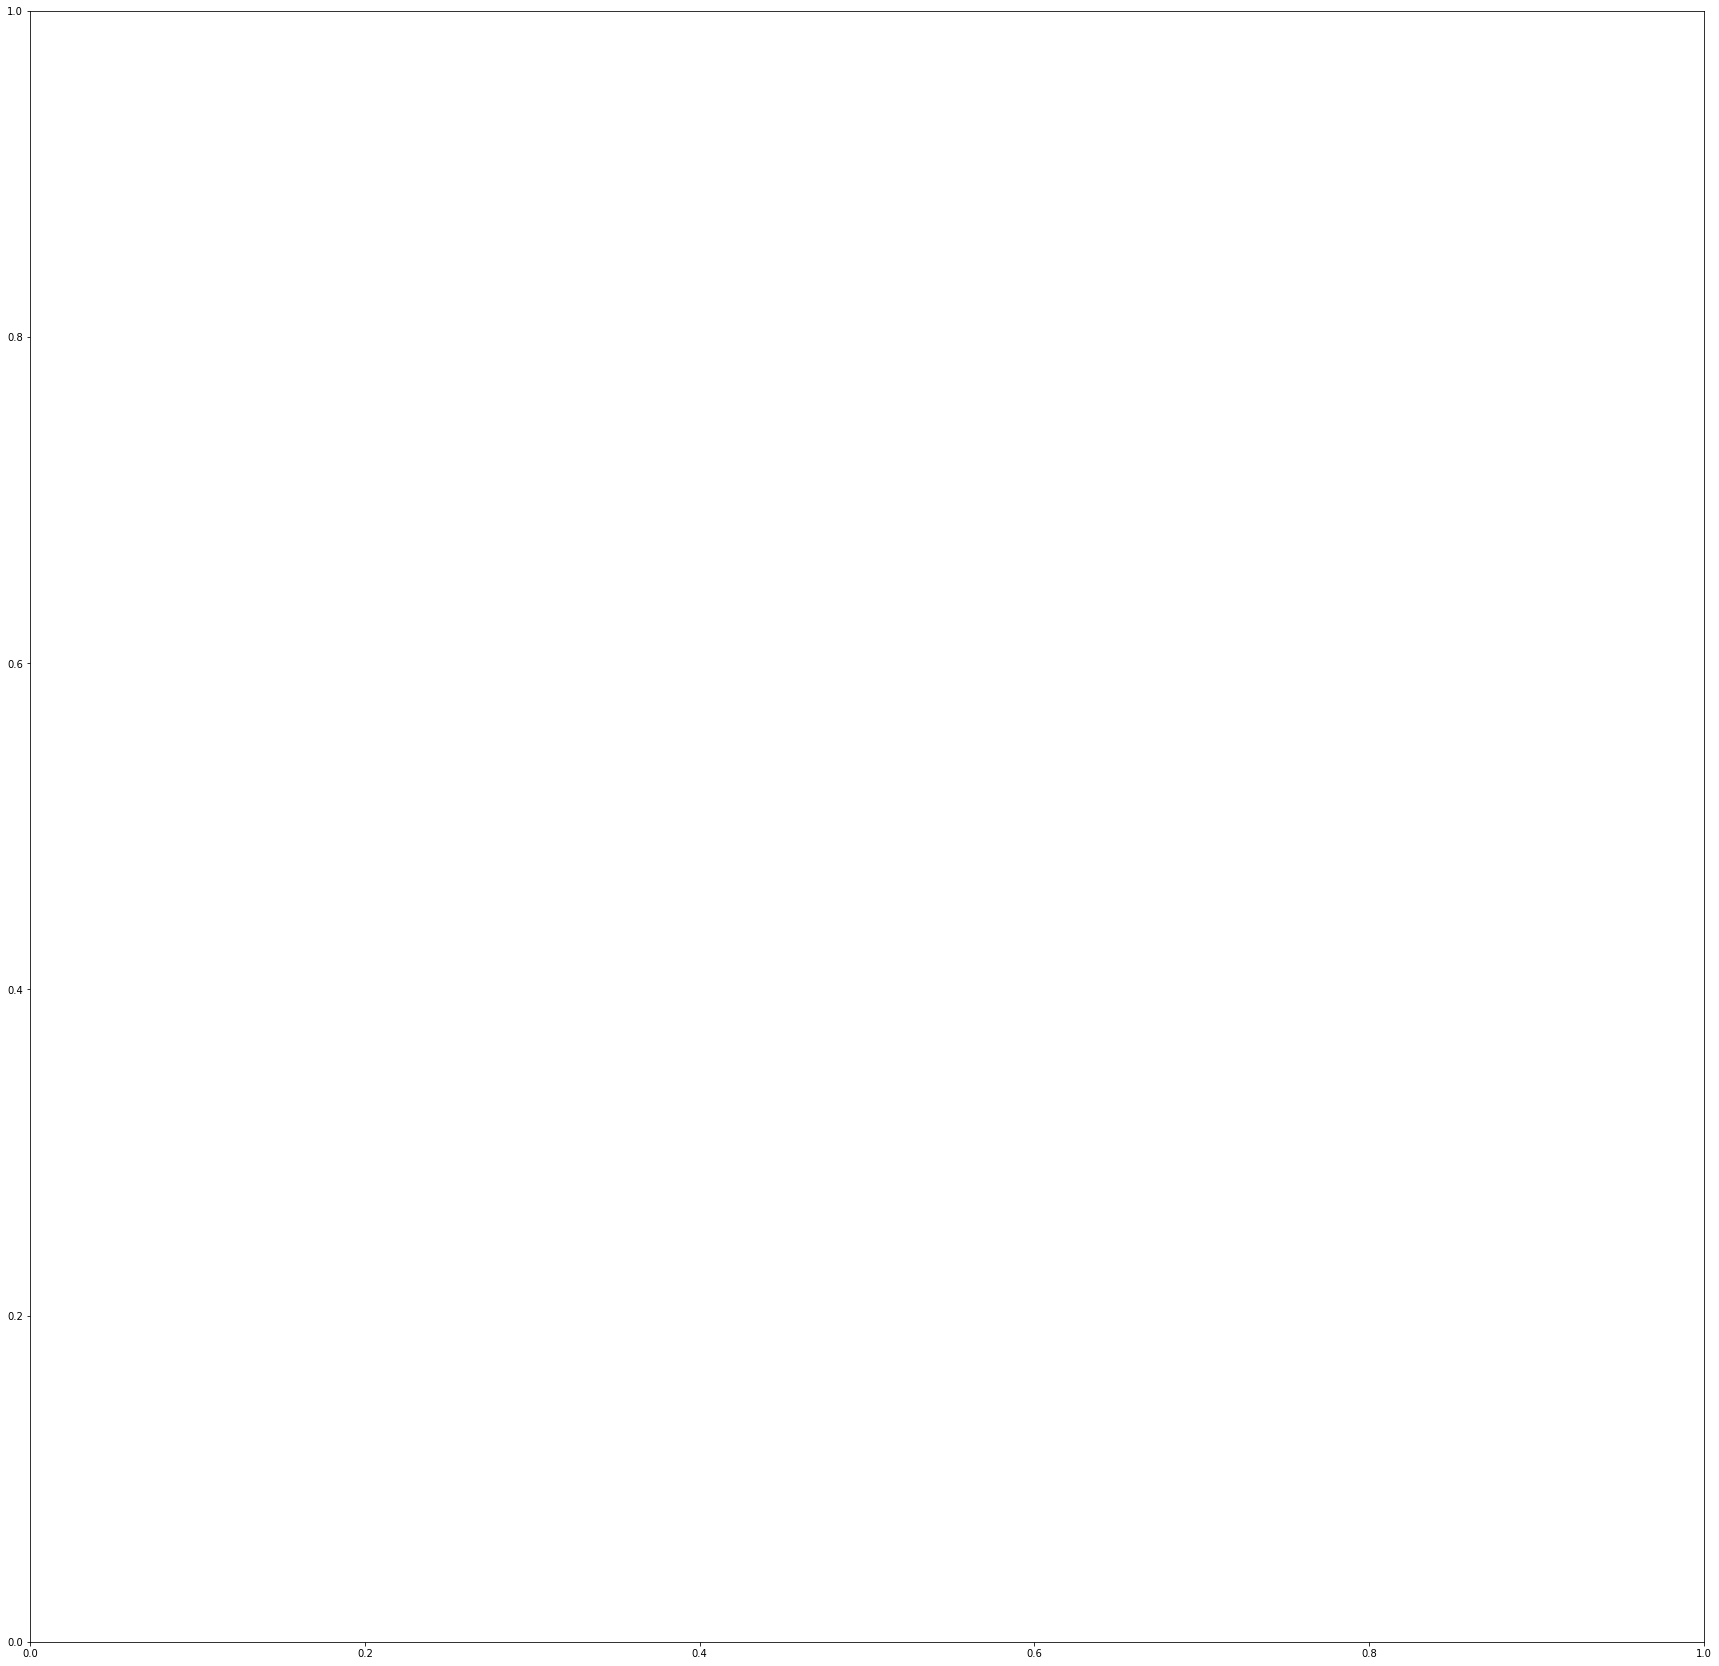

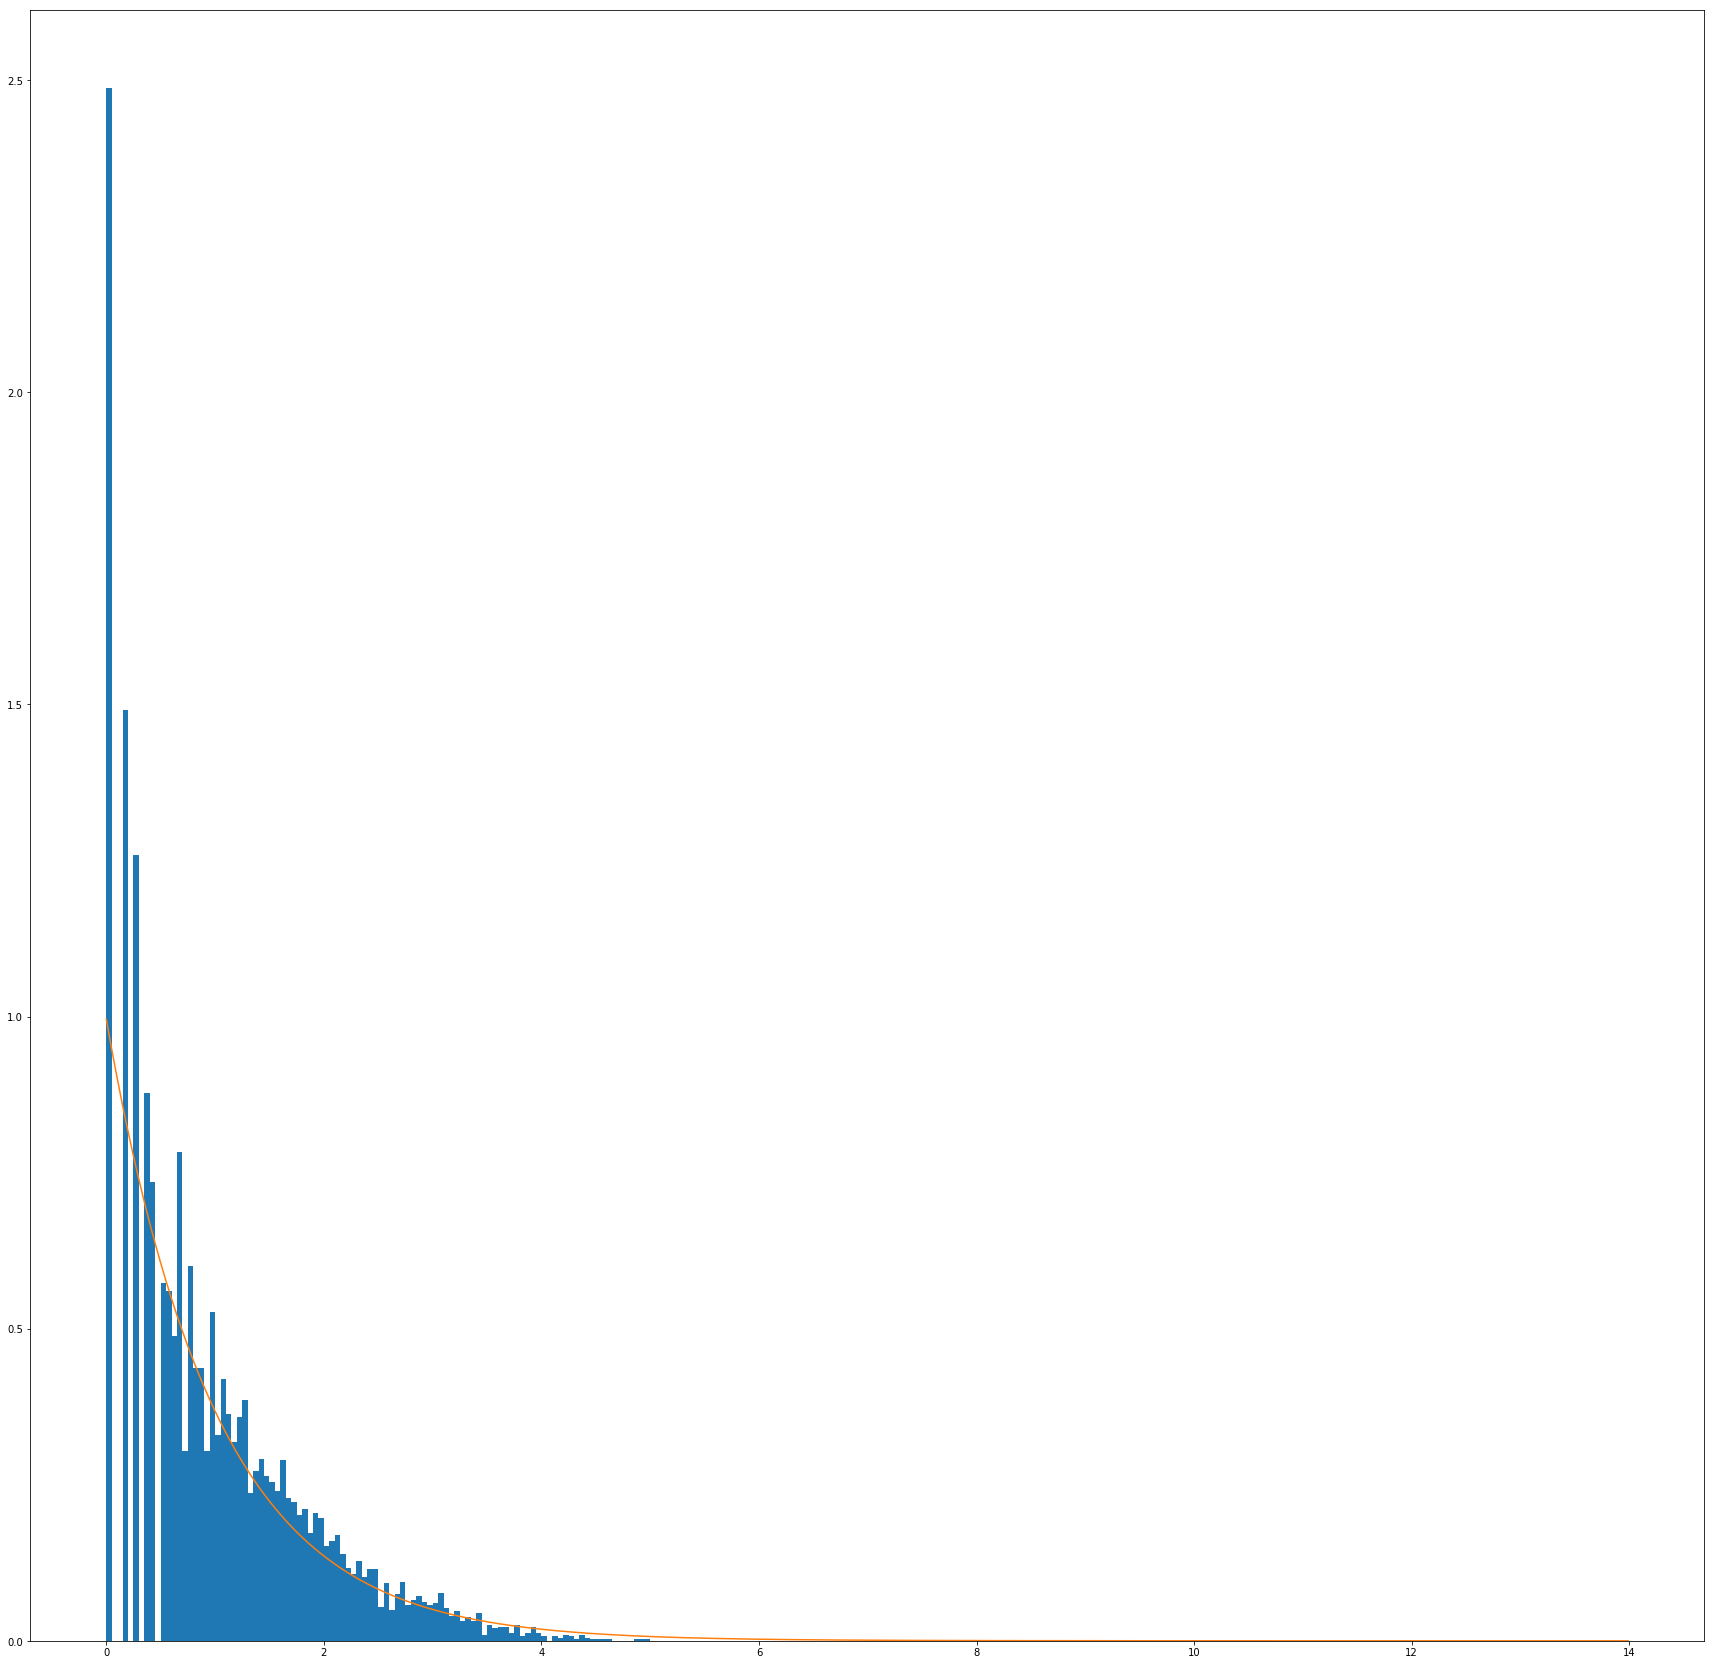

In [10]:
import math
def exp_mle(retw):
    return sum(retw) / len(retw)
def plot_exp(lam, x, ax):
    ax.plot(x, [lam * math.exp(-lam * t) for t in x])
    plt.show()
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(log_retweets2, bins = 100, density = True)
plot_exp(exp_mle(log_retweets2), np.arange(0, 14, 0.01), ax)

In [32]:
n, bins, patches = ax.hist(log_retweets, bins = 100, density = True)

In [42]:
#print(n)
print(len(log_retweets[log_retweets == 0]) / len(log_retweets))
#print(bins)

0.2325648139290156


In [44]:
print((len(log_retweets[log_retweets <= 0.7]) - len(log_retweets[log_retweets <= 0.6]))/ len(log_retweets))

0.09547498325839472


In [45]:
print((len(log_retweets[log_retweets <= 1.1]) - len(log_retweets[log_retweets <= 1]))/ len(log_retweets))

0.05720845690232469


In [46]:
print((len(log_retweets[log_retweets <= 1.4]) - len(log_retweets[log_retweets <= 1.3]))/ len(log_retweets))

0.04831148952453841


In [48]:
probbs = [0.2325648139290156, 0.09547498325839472, 0.05720845690232469, 0.04831148952453841]

0.4335597436142734


In [26]:
log_retweets5 = log_retweets[log_retweets > 1.4]
min_log2 = min(log_retweets5)
max_log2 = max(log_retweets5)
log_retweets5 = (log_retweets5 - min_log2) * 4.5 / (max_log2 - min_log2)

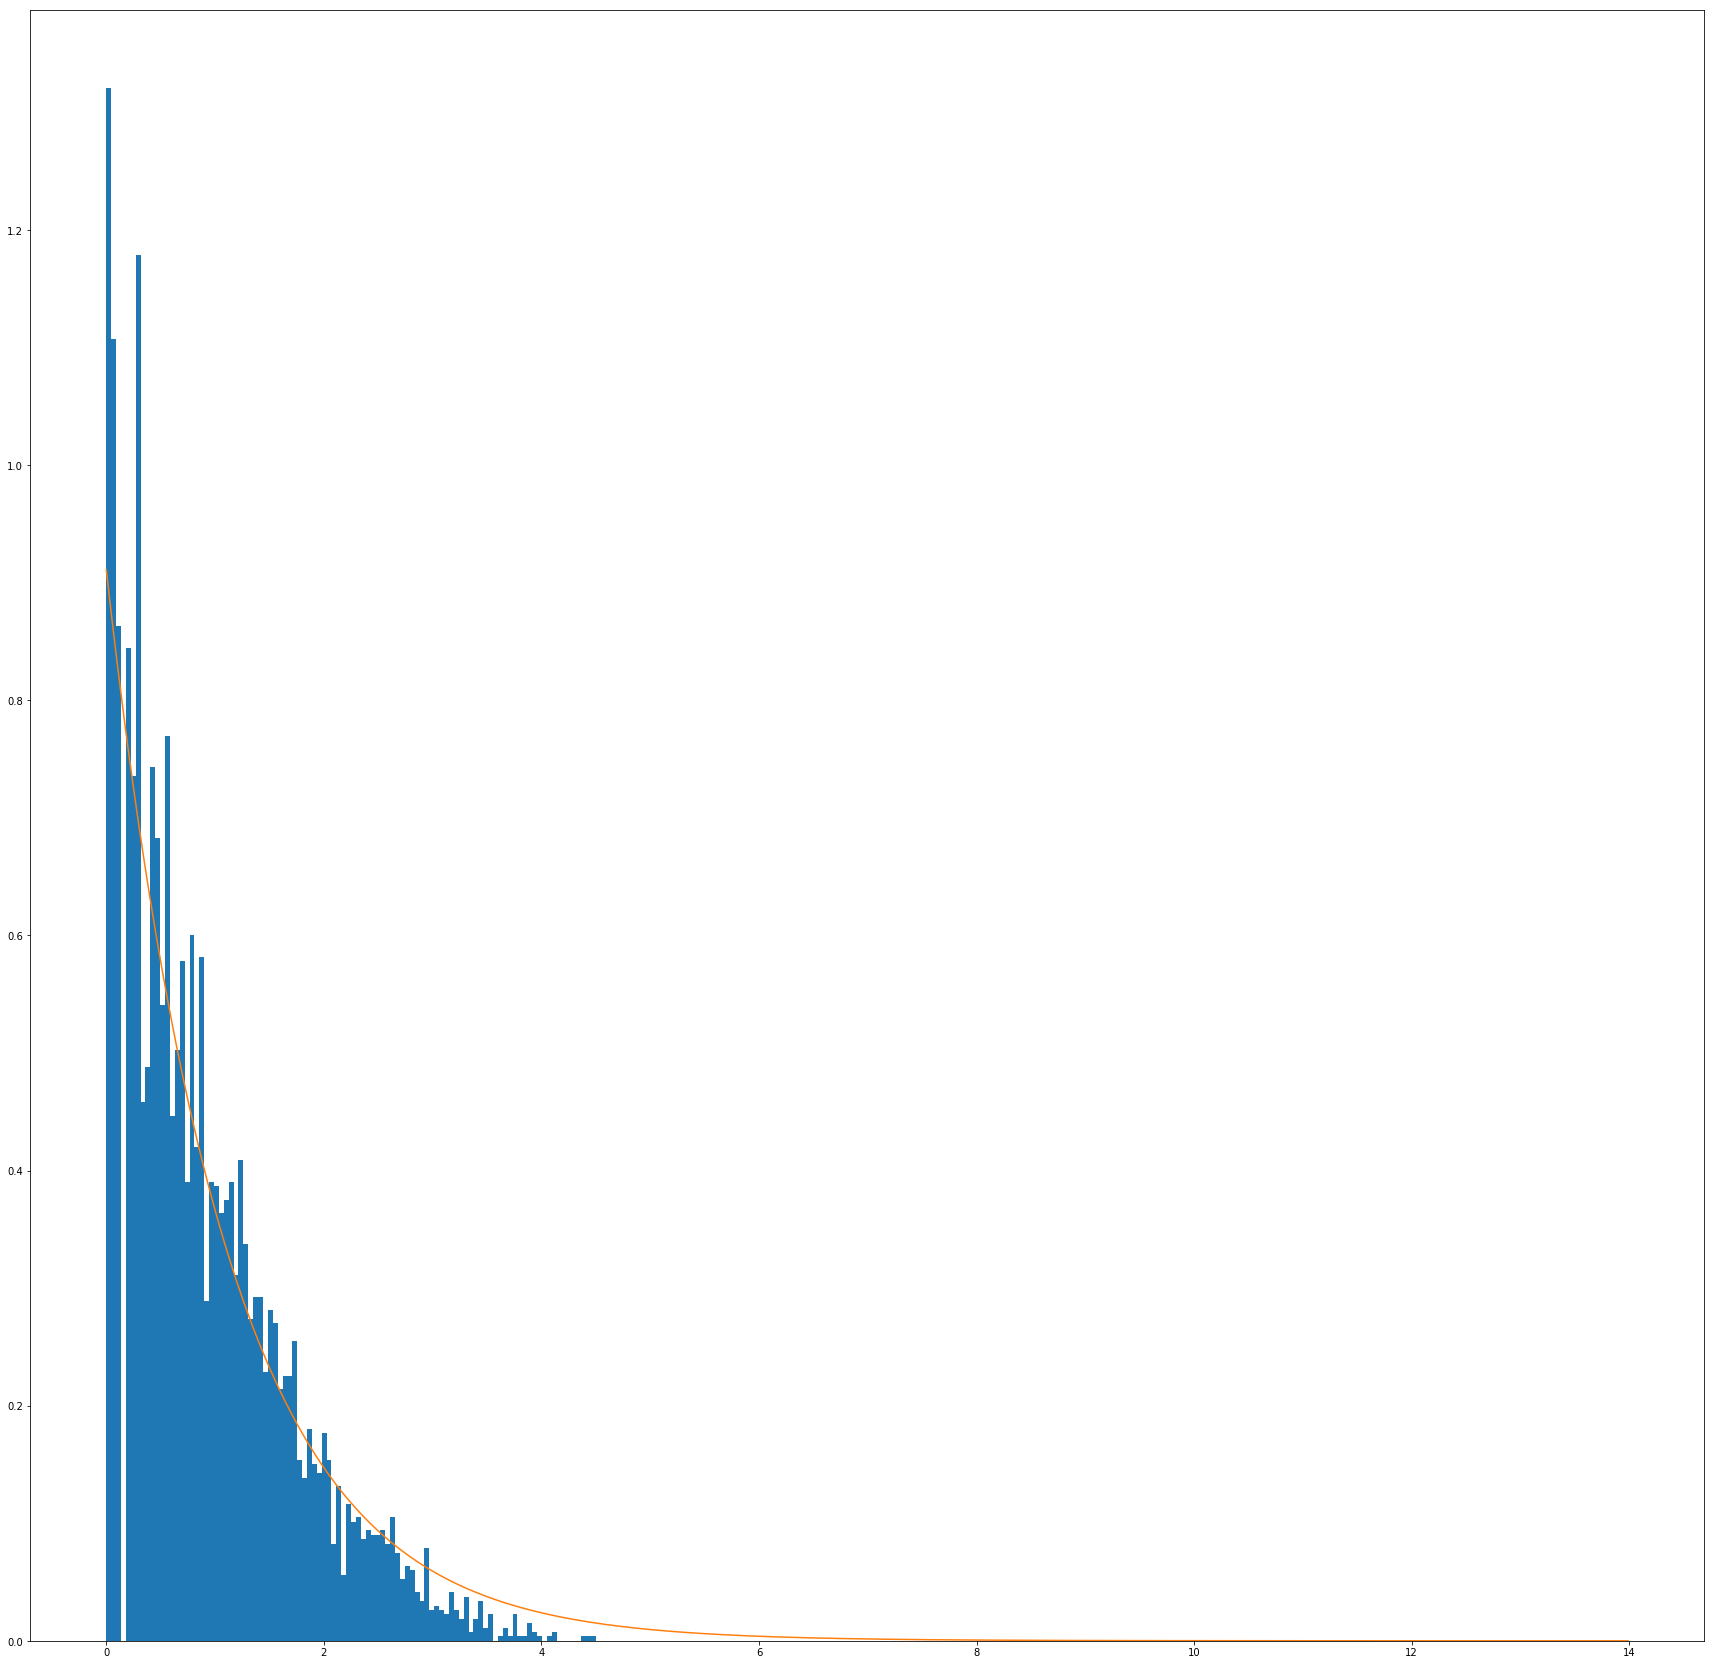

In [27]:
figg, axx = plt.subplots(nrows = 1, ncols = 1)
axx.hist(log_retweets5, bins = 100, density = True)
plot_exp(exp_mle(log_retweets5), np.arange(0, 14, 0.01), axx)

In [60]:
def sample_from_mixed_dist(choices, probs, lam, scale, min_minus, rangee, prob):
    
    if np.random.choice(a = [0, 1], p = [prob, 1 - prob]) < 1:
        return np.random.choice(a = choices, p = probs)
    else:
        return np.random.exponential(scale = 1 / lam) * rangee / scale + min_minus


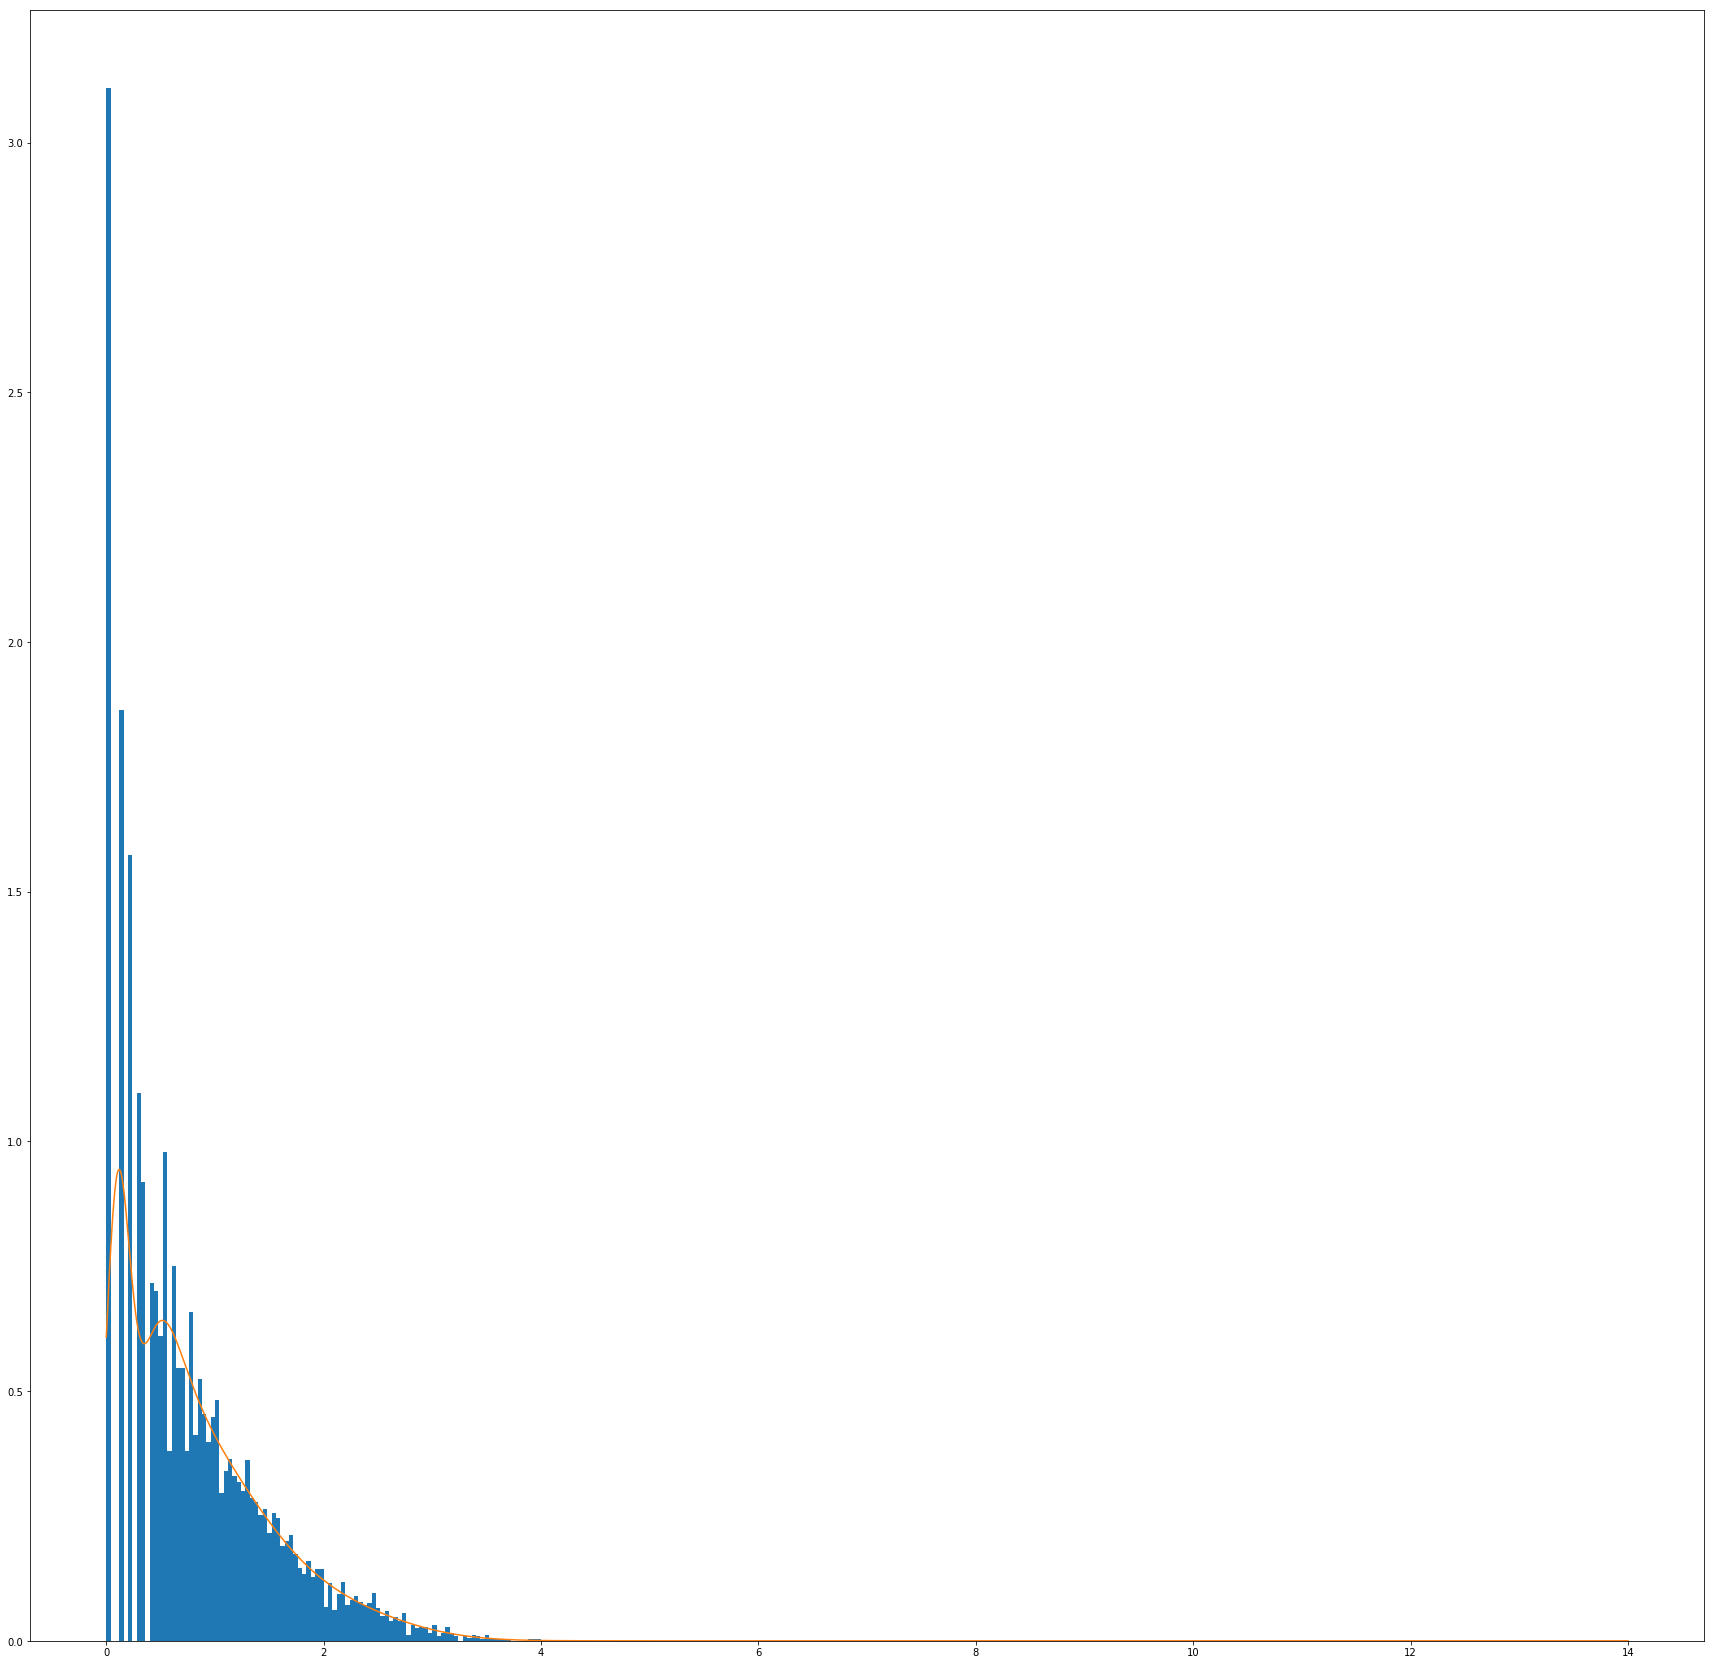

In [37]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 1)
ax1.hist(log_retweets2, bins = 100, density = True)
gmm = mix.GMM(n_components = 10, covariance_type = 'full')
gmm = gmm.fit(np.expand_dims(log_retweets2, 1))
gmm_x = np.linspace(0, 14, 5000)
gmm_y = np.exp(gmm.score(gmm_x.reshape(-1, 1)))
ax1.plot(gmm_x, gmm_y)
plot_exp(exp_mle(log_retweets), np.arange(0, 14, 0.01), ax)

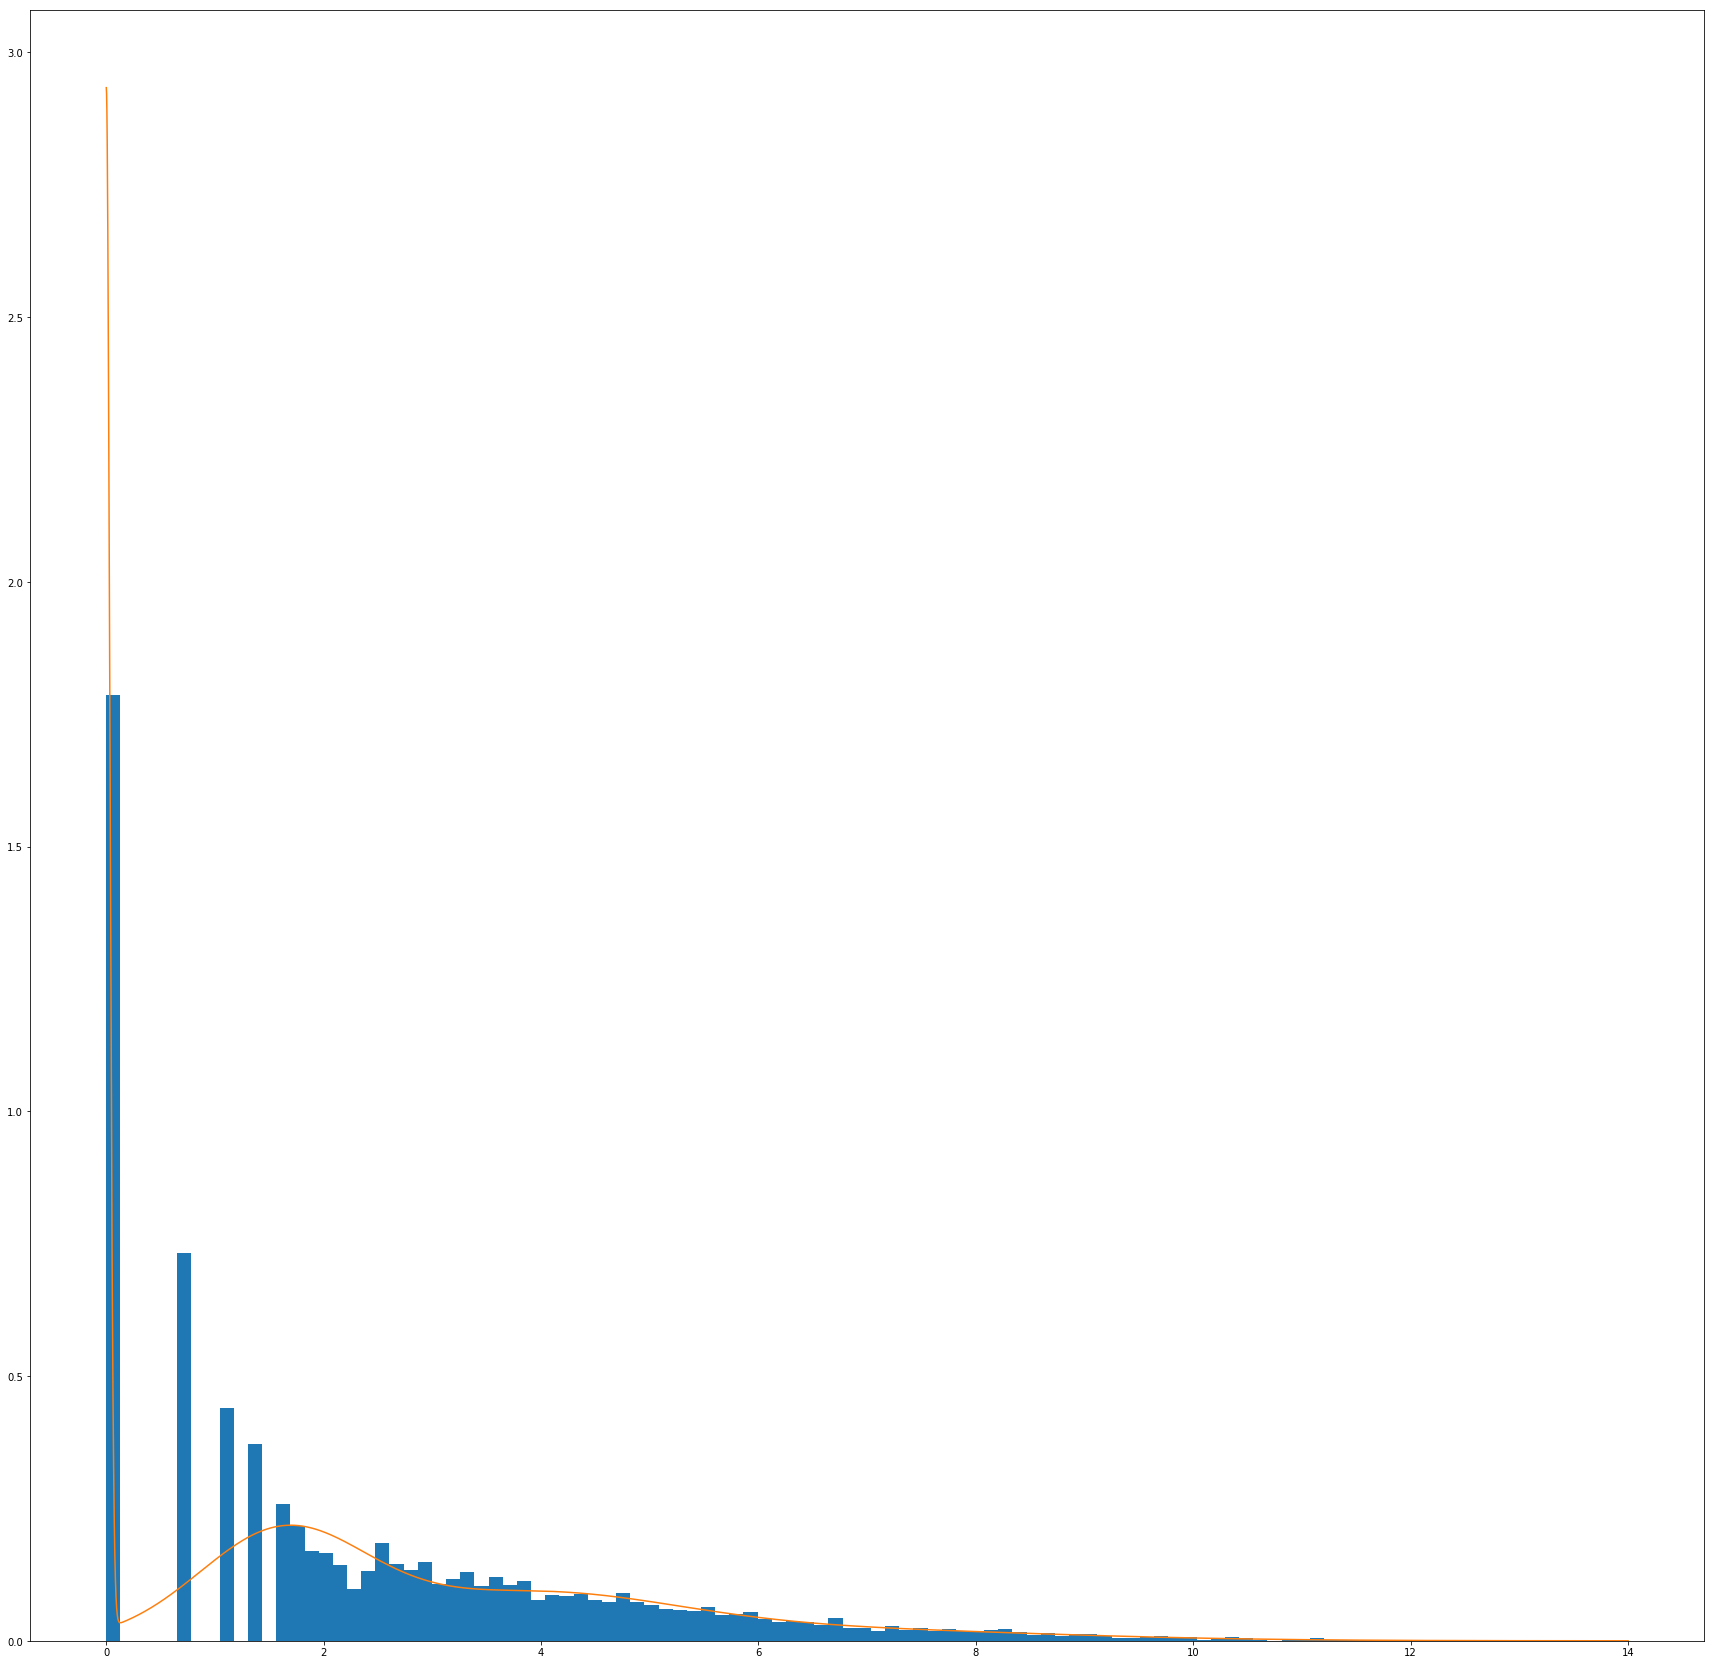

In [9]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 1)
ax1.hist(log_retweets, bins = 100, density = True)
gmm = mix.GMM(n_components = 4, covariance_type = 'full')
gmm = gmm.fit(np.expand_dims(log_retweets, 1))
gmm_x = np.linspace(0, 14, 5000)
gmm_y = np.exp(gmm.score(gmm_x.reshape(-1, 1)))
ax1.plot(gmm_x, gmm_y)
plot_exp(exp_mle(log_retweets), np.arange(0, 14, 0.01), ax)

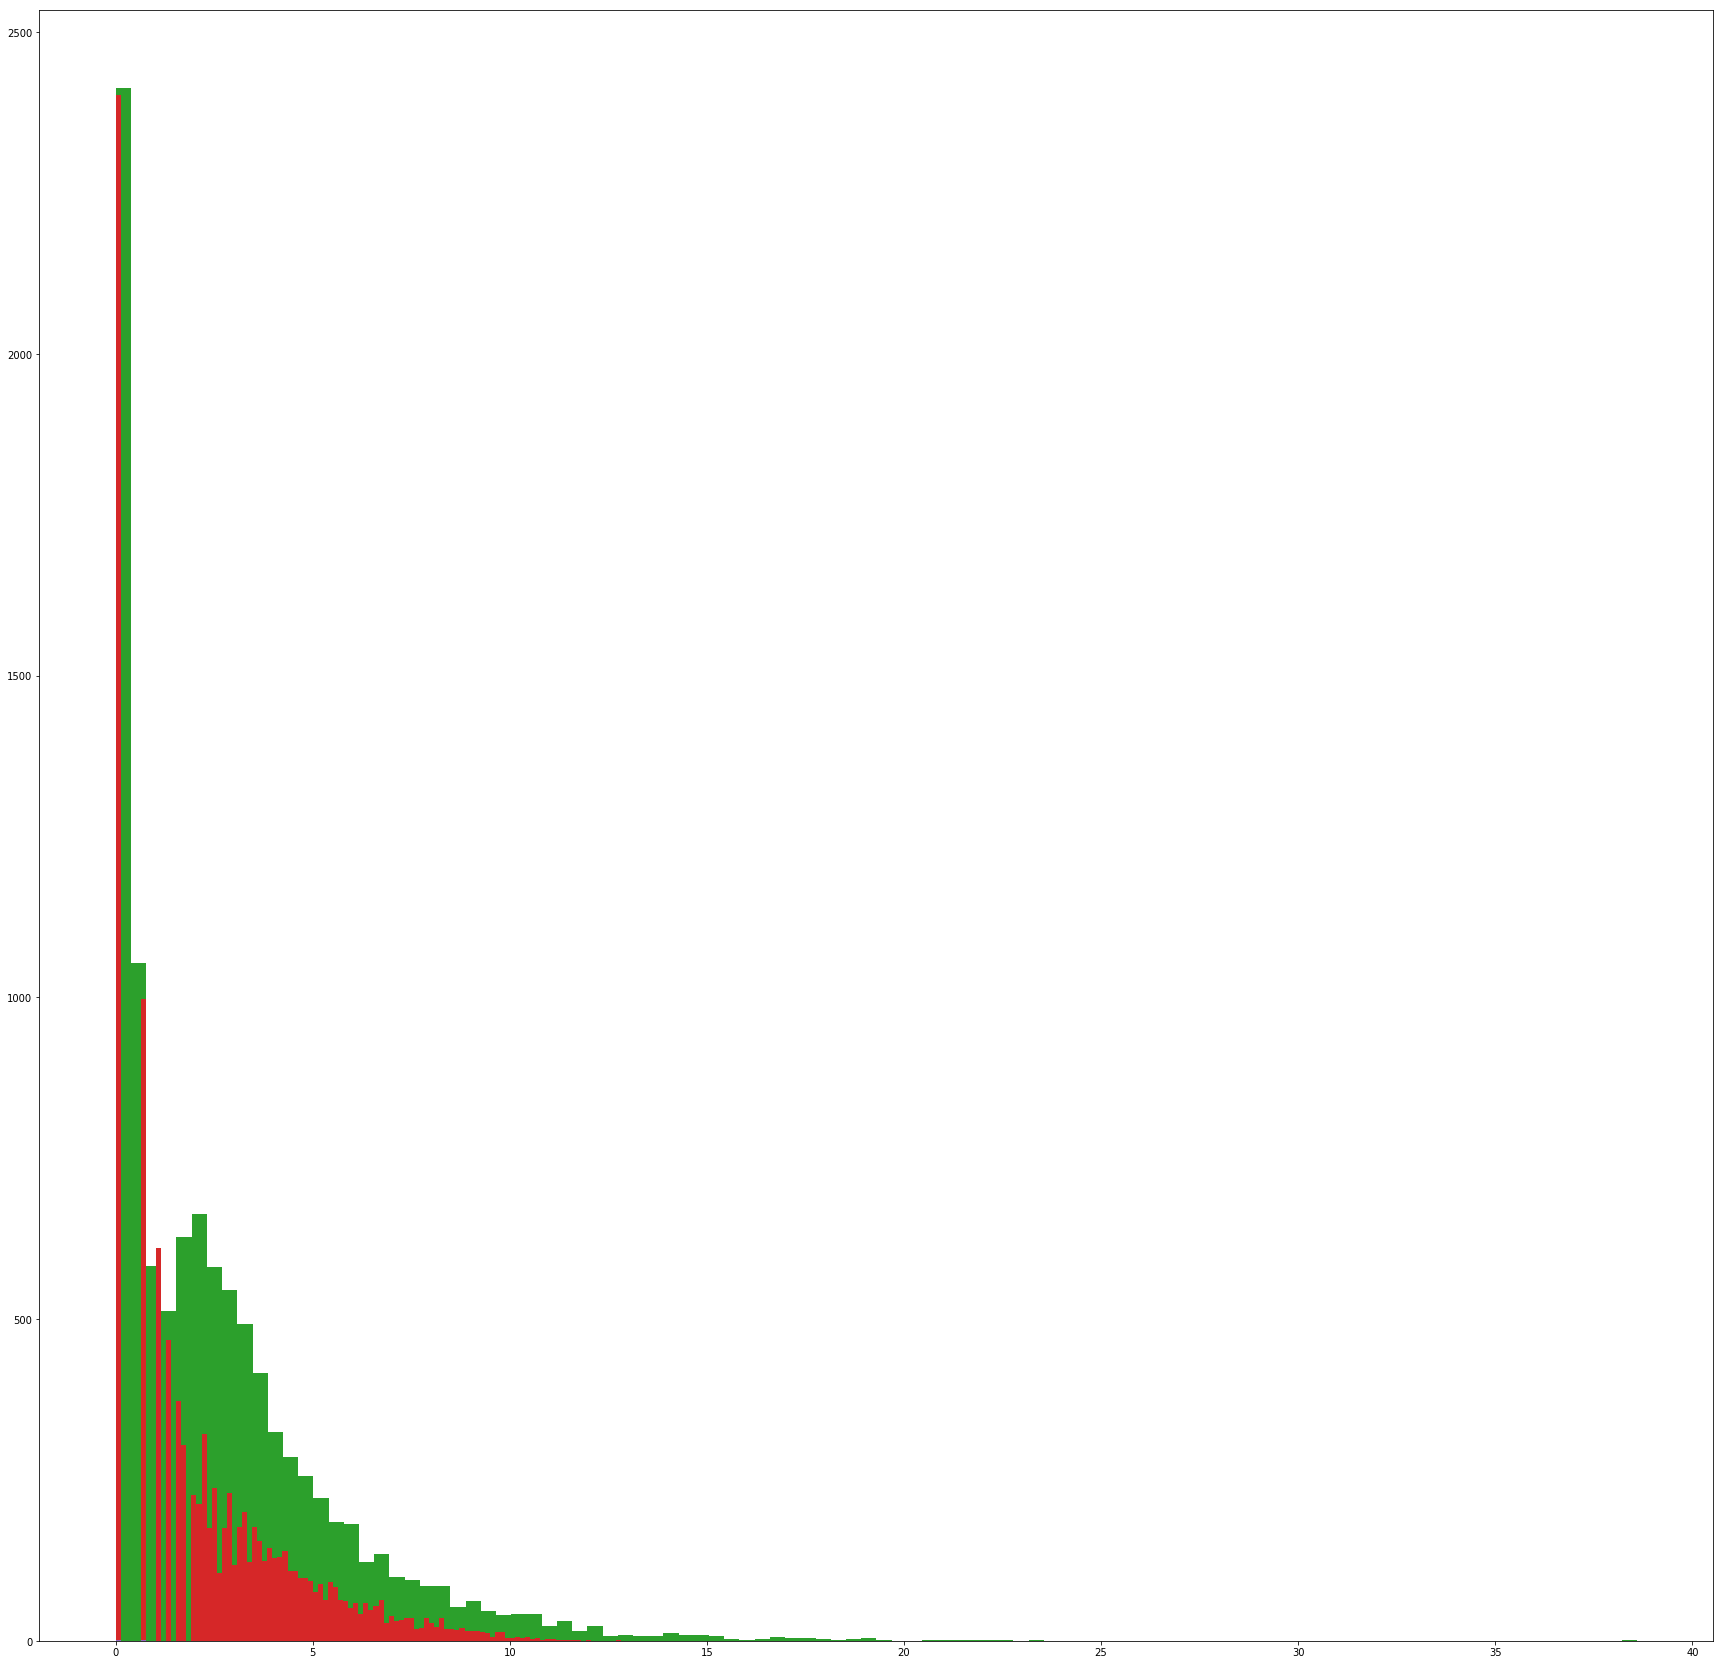

In [71]:
log_retweets2 = np.log(df2["retweets"] + 1)
#min_tweet = min(log_retweets)
#max_tweet = max(log_retweets)
#tweet_range = max_tweet - min_tweet
#plt.hist((log_retweets - min_tweet) / tweet_range, bins = 100)
na, binss, patchess = plt.hist(log_retweets2, bins = 100, density = True)
plt.show()

In [61]:
mle_lam = exp_mle(log_retweets5)
choices = [0, np.log(2), np.log(3), np.log(4)]
prob_sum = sum(probbs)
norm_probs = [i / prob_sum for i in probbs]
samples = [sample_from_mixed_dist(choices, norm_probs, mle_lam, 4.5, min_log2, (max_log2 - min_log2), prob_sum) for i in range(len(log_retweets2))]

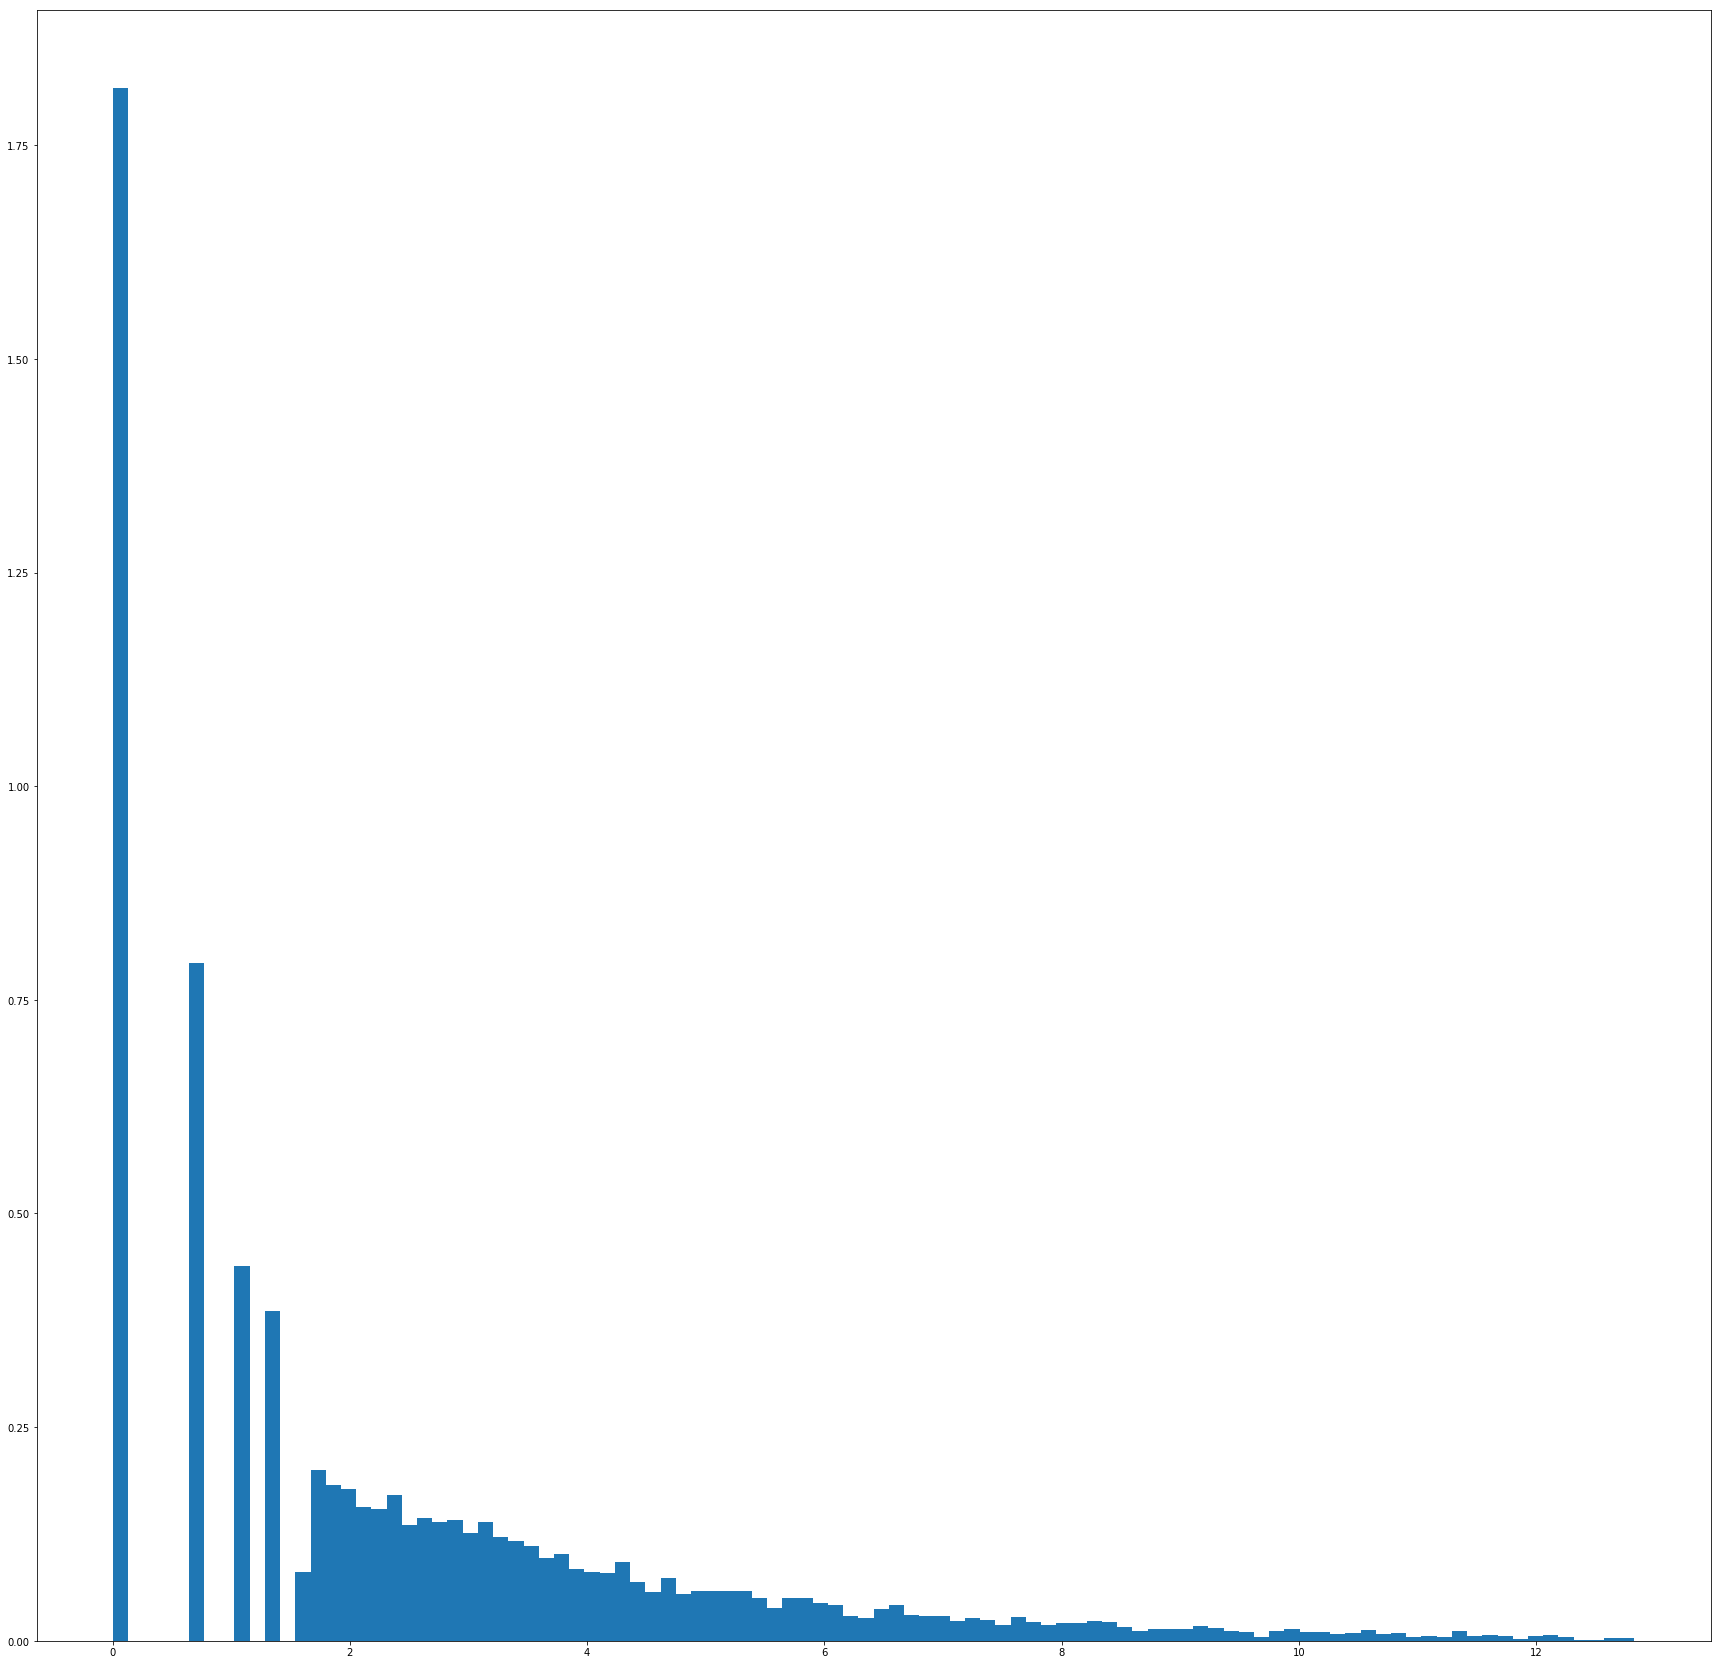

In [72]:
plt.hist(samples, bins = binss, density = True)
plt.show()

In [74]:
def diff_prob(samples, x):
    n, bins, patches = plt.hist(samples, bins = binss)
    n2, bins2, patches2 = plt.hist(x, bins = binss)
    #print(n)
    #print(n2)
    print(sum(abs(n2 - n)) / 2)
diff_prob(samples, log_retweets2)

945.0


In [17]:
print(df["retweets"])

2344     5
4778     0
3469     1
4117     1
5036     1
5517     0
6133     0
10308    1
4808     0
4118     0
5538     0
3754     0
7653     1
6404     1
9413     1
2303     1
4116     1
624      0
6840     0
7163     0
4787     1
7178     0
10311    1
6408     0
4762     0
5489     1
614      1
7102     1
9427     0
4758     0
        ..
10317    0
10324    2
10325    1
10335    0
10393    1
10394    0
10401    0
10404    0
10407    0
10409    1
10415    0
10416    0
10418    1
10419    0
10420    0
10421    0
10423    0
10425    1
10427    0
10428    0
10429    1
10432    0
10434    1
10437    0
10438    1
10440    0
10442    0
10444    0
10446    0
10447    1
Name: happy_words, dtype: int64


In [27]:
df["total_words"] = df["happy_words"] + df["sad_words"]
df["has_retweet"] = df["retweets"].map(lambda x: min(1, x))
#words_range = [i for i in range(total_words.min(), total_words.max() + 1)]
print(df.groupby(["total_words", "has_retweet"]).size())
print(df.groupby(["happy_words", "has_retweet"]).size())
print(df.groupby(["sad_words", "has_retweet"]).size())

total_words  has_retweet
0            0              1527
             1              4303
1            0               669
             1              2501
2            0               182
             1               940
3            0                48
             1               238
4            0                 5
             1                31
5            1                 9
dtype: int64
happy_words  has_retweet
0            0              1841
             1              5762
1            0               491
             1              1802
2            0                84
             1               393
3            0                10
             1                61
4            0                 5
             1                 2
5            1                 2
dtype: int64
sad_words  has_retweet
0          0              2013
           1              6026
1          0               354
           1              1585
2          0                58
           1        

In [26]:
print(res_df)

sad_words  has_retweet
0          0              2013
           1              6026
1          0               354
           1              1585
2          0                58
           1               351
3          0                 6
           1                54
4          1                 4
5          1                 2
dtype: int64


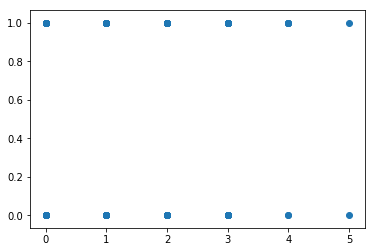

In [15]:

plt.bar(words_range, df["retweets"].map(lambda x: min(1, x)))
plt.show()

In [27]:
df3 = pd.read_csv("politician_data_fullset.csv", index_col = 0, low_memory = False)
df3.drop(df3.columns[list(range(14, len(df3.columns)))], axis = 1, inplace=True)

In [28]:
df3["retweets"] = pd.to_numeric(df3["retweets"], errors = "coerce")
df3.dropna(inplace = True)
print(df3.shape)

(84231, 14)


In [29]:
df3.sort_values(by=["retweets"], ascending=False, inplace=True)
print(df3.head())

       direct_reply    year  month_sin  month_cos  time_since_posted  \
53002           0.0  2017.0  -0.866025  -0.500000       2.258562e+07   
19124           0.0  2017.0  -0.500000   0.866025       1.397182e+07   
18945           0.0  2018.0   0.866025   0.500000       5.861774e+06   
34155           0.0  2018.0   0.866025   0.500000       6.443694e+06   
34324           0.0  2018.0   0.500000   0.866025       9.136650e+06   

       is_quote  hashtags  user_mentions  medias  urls  english  favourites  \
53002       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
19124       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
18945       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
34155       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
34324       0.0       0.0            1.0     0.0   0.0      1.0         0.0   

                                             tweet_words   retweets  
53002  RT @BarackObama

In [37]:
def ranking_game2():
    it1 = np.random.randint(len(df3)//10)
    it2 = np.random.randint(len(df3)//10) + 9*len(df3)//10
    if np.random.rand() < 0.5:
        it1,it2 = (it2,it1)
    
    print(df3.iloc[it1]["tweet_words"])
    print("-------")
    print(df3.iloc[it2]["tweet_words"])
    print("-------")
    
    guess = int(input("Which tweet has more retweets (1/2)?"))
    
    print("True Rating: {} / {}".format(df3.iloc[it1]["retweets"], df3.iloc[it2]["retweets"]))
    correct = ((guess == 1) and (it1 < it2)) or ((guess == 2) and (it1 > it2))
    print("{}".format("Correct!" if correct else "Incorrect!"))

In [47]:
ranking_game2()

I had a dream last night that someone cut all my hair off while I was sleeping 😱 What does this mean!
-------
There are 118 House Republicans in seats that went for Trump by less than this district. Democrats need to win 24 s… https://t.co/6sZU4758x6
-------
Which tweet has more retweets (1/2)?2
True Rating: 0.0 / 904.0
Correct!
